In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def importData(file):

    # open json file
    with open(file) as f:
        data = json.load(f)

    keys = [i for i in data.keys()]

    d_vectors = {}

    for key in keys:

        d_vectors[key] = {}
        vectors = data[key]["vectors"]

        measurement = data[key]["attributes"]["measurement"]
        repetition = data[key]["attributes"]["repetition"]
        configs = data[key]["config"]
        mergedConfigs={}
        for config in configs:
            mergedConfigs.update(config)
        timeLimit = mergedConfigs["sim-time-limit"]

        d_vectors[key]["measurement"] = measurement
        d_vectors[key]["repetition"] = int(repetition)
        
        assert timeLimit.endswith('s'), "Time limit format is incorrect"
        timeLimit = timeLimit[:-1]  # Remove the 's' at the end
        d_vectors[key]["timeLimit"] = int(timeLimit)

        for a in vectors:

            module = a["module"]
            name = a["name"]

            if not module in d_vectors[key]:
                d_vectors[key][module] = {}
            d_vectors[key][module][name] = {}

            d_vectors[key][module][name]["times"] = a["time"]
            d_vectors[key][module][name]["values"] = a["value"]

    return d_vectors


d_vectors = importData("../multicore_sched/simulations/test.json")

In [3]:
firstIndex=list(d_vectors)[0]

In [4]:
firstIndex=list(d_vectors)[0]
print(d_vectors[firstIndex]['Computer.scheduler'].keys())

dict_keys(['turnaroundTime:vector', 'waitedReadyTime:vector', 'numProcReady:vector', 'numBusyCpus:vector', 'numBusyCpus:vector(timeavg)'])


In [5]:
iterationvars=['numCpus','meanProcessDuration']

In [6]:
measurements=[]
numRepetitions=0

for key in d_vectors:

    measurement=d_vectors[key]['measurement']
    repetition=d_vectors[key]['repetition']

    if not measurement in measurements:
        measurements.append(measurement)
    
    numRepetitions=max(numRepetitions,repetition+1)

In [7]:
import colorsys
def getColors(numColors,numVariations):
    colors=[]
    for i in range(numColors):
        hue = i/numColors
        colors.append([])
        for j in range(numVariations):
            lightness = 0.4 + j / numVariations / 3  # Adjusting to reduce white
            saturation = 0.6 + j / numVariations / 3  # Adjusting to reduce white
            colors[i].append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

numColors = len(measurements)
numVariations = numRepetitions
colors = getColors(numColors, numVariations)

In [8]:
def showColors():
    # Plot colors
    fig, ax = plt.subplots(figsize=(numVariations, numColors))
    for i, row in enumerate(colors):
        for j, color in enumerate(row):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))

    ax.set_xlim(0, numVariations)
    ax.set_ylim(0, numColors)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()
# showColors()

In [9]:
def measurementLabel(measurement, endline=True):
    for j, iterationvar in enumerate(iterationvars):
        measurement = measurement.replace(f"${j}", f"{iterationvar}")
    if endline:
        measurement = measurement.replace(', ', '\n')
    return measurement

/tmp/ipykernel_64856/595061059.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


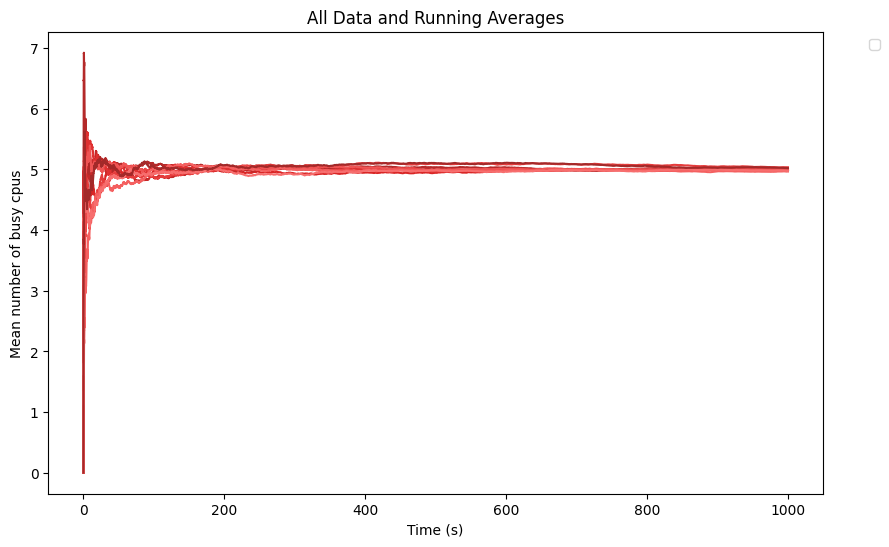

In [10]:
for key in d_vectors:

    measurement=d_vectors[key]['measurement']
    repetition=d_vectors[key]['repetition']
    timeLimit=d_vectors[key]['timeLimit']

    color=colors[measurements.index(measurement)][repetition]

    times = d_vectors[key]["Computer.scheduler"]["numBusyCpus:vector(timeavg)"]["times"]
    values = d_vectors[key]["Computer.scheduler"]["numBusyCpus:vector(timeavg)"]["values"]

    plt.plot(times, values,color=color)

# Plt labels
for i, measurement in enumerate(measurements):
    plt.plot([], [], color=colors[i][0], label=f'{measurementLabel(measurement)}')

plt.xlabel('Time (s)')
plt.ylabel('Mean number of busy cpus')
plt.title('All Data and Running Averages')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [34]:

def avg_and_std(values):
    average = np.average(values)
    # Biased variance
    variance = np.average((values-average)**2)
    return (average, np.sqrt(variance))

def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    # Biased variance
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

def find_nearest_small_value(key, sorted_li):
    less=[i for i in sorted_li if i <= key]
    if len(less)==0:
        return 0
    else:
        return len(less)-1

      Time  Average  Standard Deviation
  0.000209 0.000000            0.000000
  0.000354 0.000000            0.000000
  0.000603 0.000000            0.000000
  0.001024 0.000000            0.000000
  0.001741 0.000000            0.000000
  0.002959 0.000000            0.000000
  0.005029 0.000000            0.000000
  0.008548 0.082394            0.247183
  0.014528 0.180145            0.361924
  0.024693 0.392968            0.508633
  0.041971 0.548573            0.612715
  0.071338 0.946752            0.830124
  0.121253 1.509494            1.151692
  0.206093 2.131376            1.278391
  0.350294 2.887428            1.398378
  0.595393 3.371808            1.588816
  1.011985 3.964476            1.262734
  1.720065 4.371480            1.007106
  2.923583 4.474189            0.673268
  4.969194 4.649545            0.514172
  8.446105 4.613206            0.487764
 14.355788 4.736121            0.347122
 24.400436 4.898645            0.208004
 41.473258 4.947899            0.117581


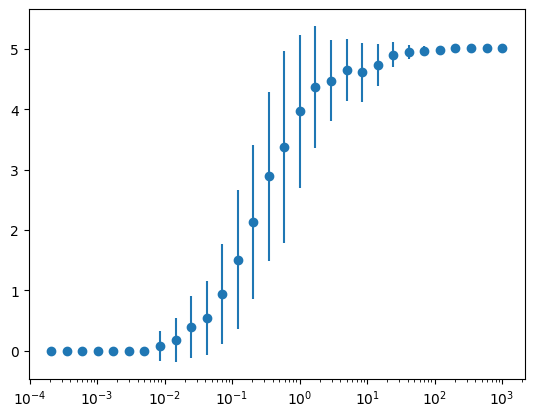

In [43]:
import pandas as pd

allTimeValues = []

for key in d_vectors:
    measurement = d_vectors[key]["measurement"]
    repetition = d_vectors[key]["repetition"]
    timeLimit = d_vectors[key]["timeLimit"]
    
    times = d_vectors[key]["Computer.scheduler"]["numBusyCpus:vector(timeavg)"]["times"]
    values = d_vectors[key]["Computer.scheduler"]["numBusyCpus:vector(timeavg)"]["values"]

    allTimeValues.append((times, values))

timesToTest=allTimeValues[0][0]

#take 10 values from timesToTest log distrubuted
timesToTest = np.logspace(np.log10(timesToTest[0]), np.log10(timesToTest[-1]), num=30)

avgs = []
stds = []
table_data = []

for time in timesToTest:
    matching_values = []
    # print(time)

    
    # Find values corresponding to the largest time <= `time`
    for times, vals in allTimeValues:
        index=find_nearest_small_value(time, times)
        matching_values.append(vals[index])

    avg, std = avg_and_std(matching_values)
    # print(matching_values)
    # print(avg,std)
    avgs.append(avg)
    stds.append(std)
    table_data.append([time, avg, std])


df = pd.DataFrame(table_data, columns=["Time", "Average", "Standard Deviation"])
print(df.to_string(index=False))
print("\n")

#plot avg and std
plt.errorbar(timesToTest, avgs, yerr=stds, fmt='o')
plt.xscale('log')

In [13]:
import matplotlib.pyplot as plt

# Plot standard deviation against time for each entry in plot_data
for data in plot_data:
    plt.plot(data['times'], data['std'], label=data['label'])

# Customize the plot
plt.xlabel('Stop Time')
plt.ylabel('Standard Deviation')
plt.xscale('log')
plt.title('Standard Deviation vs Stop Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


NameError: name 'plot_data' is not defined

In [34]:
#plot the 